<a href="https://colab.research.google.com/github/MoyaCar/Android-Calibration-Views/blob/master/ClasificadorDeInstrumentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento de un reconocedor de instrumentos.

Primero se conectan las librerías importantes a utilizar, en este caso el módulo de computer vision de **Fastai**, el de metricas, y conectividad con google drive para utilizar un** dataset** que voy a descargar listas de urls armadas con busquedas de google.


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = Path('/content/gdrive/My Drive/instrumentos/')
path


PosixPath('/content/gdrive/My Drive/instrumentos')

Establezco las **clases** que va a poder detectar el modelo en un array. 

In [0]:
classes = ['bajo','clasica','electrica','ukelele','contrabajo','charango']

Este bucle revisará todos los archivos de urls que ya tengo armados, creará carpetas en mi google drive y subirá las fotos correspondientes.
Además verificará las que marquen error y las borrará.

Está comentado para no ejecutar por error ya que el método puede tomar mucho tiempo.

In [0]:
#no ejecutar dos veces
#for instrumento in classes:
  #file = instrumento +'.txt'
  #destino = path/instrumento
  #destino.mkdir(parents=True, exist_ok=True)
  #download_images(path/file,destino,max_pics=200)
  #print(instrumento)
  #verify_images(path/instrumento, delete=True ,max_workers=8)

Con las imagenes en el dataset remoto ya armado, procedo a crear un DataBunch para que el modelo pueda entender y entrenar.

Como no cuento con una **carpeta de validación** para que el modelo pueda revisar qué tan bien va, le asígno un **20%** de las imagenes del dataset (**valid_pct = 0.2**).

Hago que convierta todas las imagenes a una **resolución de 480 x 480**, pero podría arrancar con menor resolución. 

Le aplico **transformaciones** varias a las imagenes, de orientación, de forma, de centralizado, etc. Una técnica muy utilizada para mejorar la capacidad de generalización del modelo.

Para el tamaño del **Bach** le asigno **32** para ganar algo de tiempo.

Finalmente le aplico lo **normalizadores** de imagenet para que las imagenes tengan valores similares de color, luminosidad, etc.


In [0]:
data = ImageDataBunch.from_folder(path, valid_pct=0.2, train = '.', size = 480, ds_tfms = get_transforms(do_flip=False), bs = 32).normalize(imagenet_stats)

Le pido al DataBunch que me muestre las primeras imagenes de su contenido, para ver que esté aplicando cambios y clases.

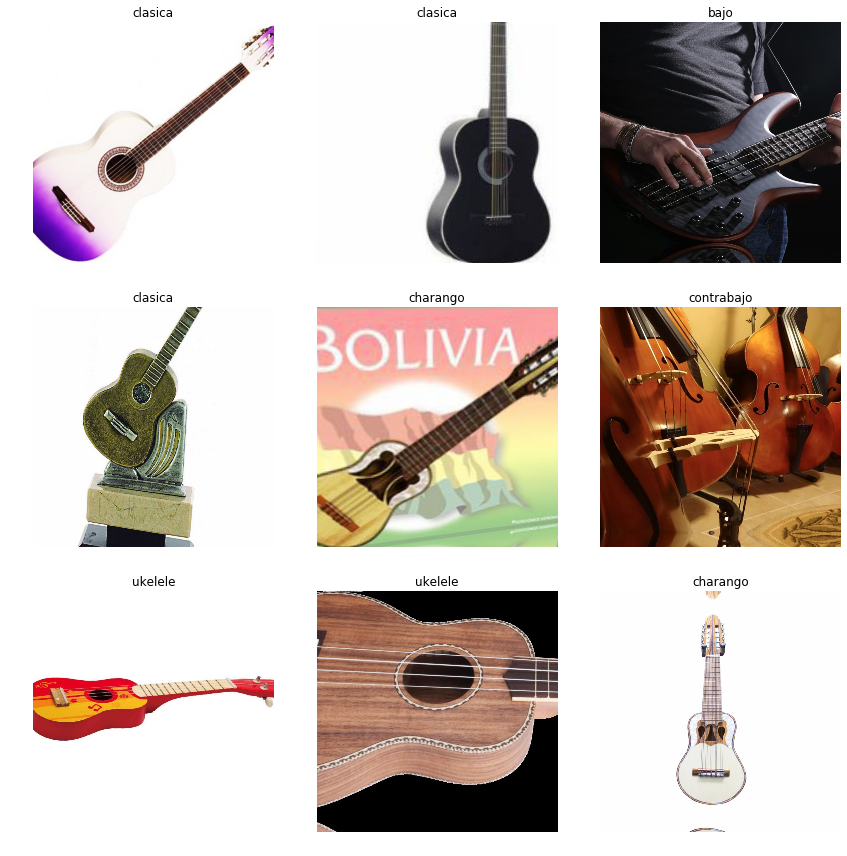

In [0]:
data.show_batch(rows = 3)

Ahora creo el **modelo de entrenamiento**, para esto vamos a utilizar un modelo de** red neuronal convolucional** (**cnn_learner**) y para su arquitectura, en vez de especificarla vamos a utilizar la de resnet, en este caso únicamente la de 34 capas. Que para iniciar será más que suficiente. 
También le pudo que me devuela la **métrica del ratio de error **durante el entrenamiento, con esto voy a poder medir que tan bien o mal va.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics= error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 37.6MB/s]


Un save del modelo sin entrenar, no es necesario pero me gusta llevar registros de este tipo.(Los modelos se guardan por defecto en la carpeta **/models/** del dataset, en este caso en el drive)

In [0]:
learn.save('instrumentos-inicial')

Comienzo con el entrenamiento, Le pido que haga** 10 épocas**, el error rate mejora fijo hasta la época 8 que vuelve a subir, posiblemente por overfitting y por falta de afinación. Voy a intentar mejorar esos valores.

In [0]:
learn.fit_one_cycle(10)

In [0]:
learn.save('instrumentos-4')

Genero una **matriz de confusión** desde el entrenamiento para ver qué clases fueron las más conflictivas y si va a ser necesario manipular el dataset, ya sea limpiandolo de imagenes conflictivas o agregando más muestras para esas clases. (Al parecer el modelo confunde mucho entre guitarras y bajos, lo cuál es entendible, mucha gente no los diferenciaría simple vista) 

In [0]:
interp= ClassificationInterpretation.from_learner(learn)

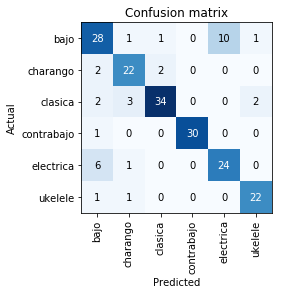

In [0]:
interp.plot_confusion_matrix()

También le pido que me muestre las **12 imagenes más conflictivas**, osea en las que más se confundió. Esto ayuda particularmente a detectar imagenes que no deberían estar en el dataset o que sería incorrecto realizar in entrenamiento con ellas, por ejemplo la imagen con dos guitarras podría ser algo conflictiva, igual dejarlas tampoco es necesariamente malo, pero saber cuáles son para poder **experimentar** a consciencia es importante.

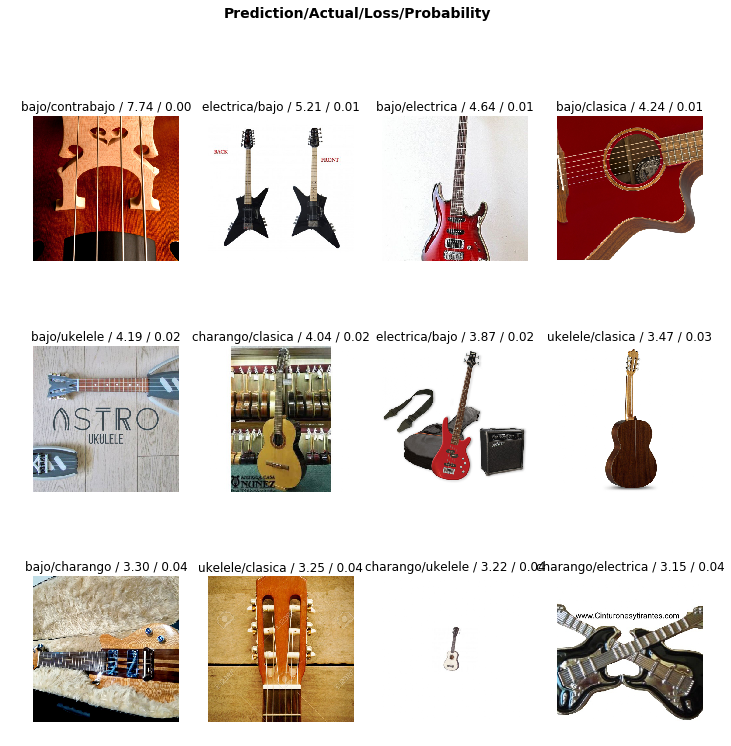

In [0]:
interp.plot_top_losses(12)

Ahora voy a pedirle al modelo que me devuelva metricas de su **Learning Rate**, con esto voy poder encontrar dónde es que el error de busqueda aumenta y definir un óptimo para mejorar los resultados.
En este caso el gráfico me muestra que cerca del valor **1e-02** las perdidas se disparan, Así que quitar este valor y mayores del entrenamiento debería ayudar. Y por otro lado dejar valores demasiados bajos tapoco aportarían demasiada ganancia por el momento. Asi que las próximas **épocas** van a correr entre los valores de **lr** de 1e_05/ 1e_02

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


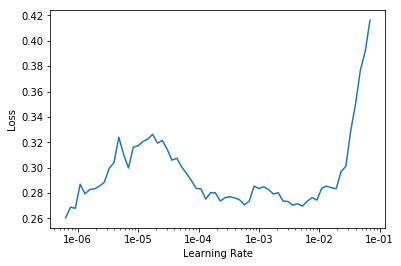

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-05, 1e-02))

Descongeo el modelo para poder seguir entrenando y en esta ocasión le pido únicamente 8 épocas y le paso el rango de learning rate, el modelo disminuye su ratio de error, pasando **87%** de posibilidades de predecir la clase de un instrumento a el **93%**, una mejora más que aceptable.

Luego de esto repetimos los pasos del afinación hasta llegar a una meseta de entrenamiento. Como se ve al final del entrenamiento, el modelo alcanza casi el **95%** de efectividad, un número bastante alto, además el modelo no cuenta con mas de 100 imagenes por clase, lo cuál podría ser poco para llegar a valores más altos y por otro lado el dataset está bastante sucio, con imagenes tramposas o poco manejadas. Un punto importante de este tipo de trabajos es saber que manipular y preparar las imagenes o los datos es posiblemente la tarea más pesada y también la más importante. Y hasta cierto punto, la más complicada.

In [0]:
learn.save('instrumentos-6-good')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

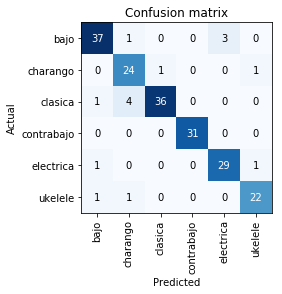

In [0]:
interp.plot_confusion_matrix()

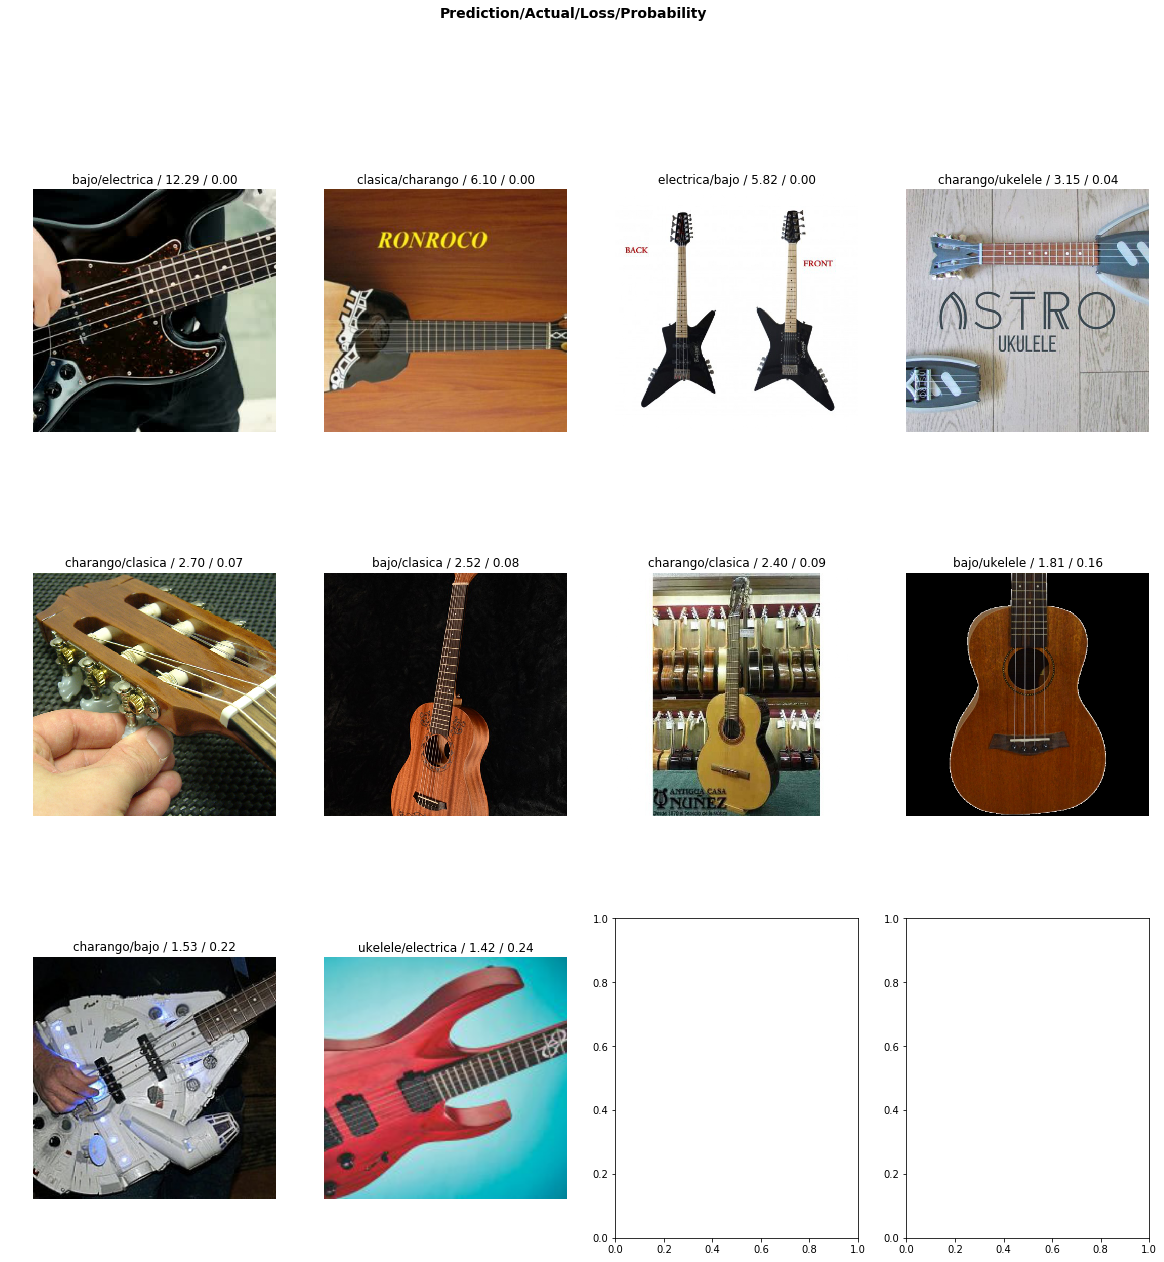

In [0]:
interp.plot_top_losses(10, figsize=(20,20))

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


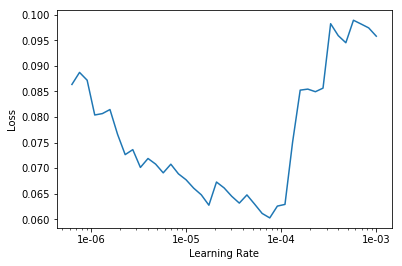

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-06,1e-04))

In [0]:
learn.save('instrumentos_7_very_good')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

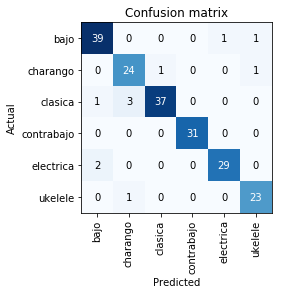

In [0]:
interp.plot_confusion_matrix()

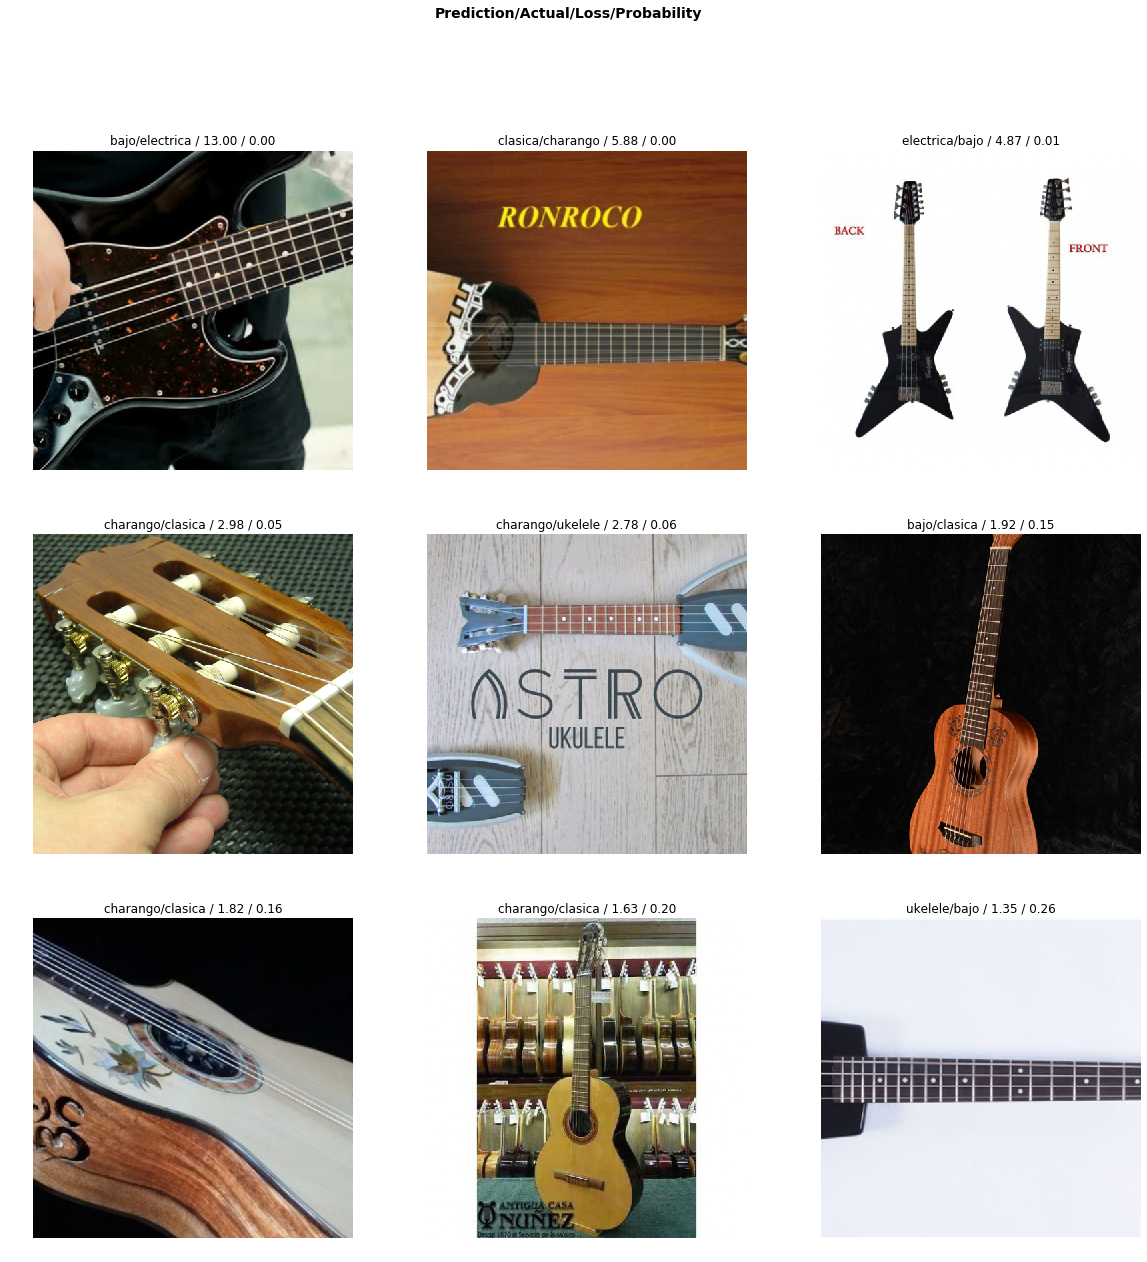

In [0]:
interp.plot_top_losses(9, figsize=(20,20))

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


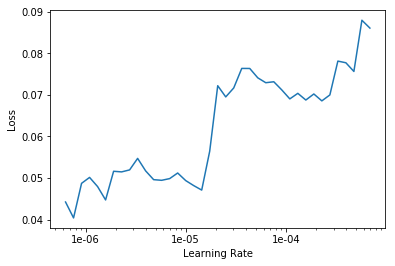

In [0]:
learn.recorder.plot()

#Hasta aca llega el entrenamieto.

In [0]:
learn.export()